<a href="https://colab.research.google.com/github/gift-framework/GIFT/blob/main/notebooks/GIFT_PINN_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<cell_type>markdown</cell_type># GIFT-Native PINN Training Notebook (v3.1.4 - CORRECTED)

Train a Physics-Informed Neural Network with built-in GIFT algebraic structure.

**Runnable on Google Colab with free T4/A100 GPU.**

## Key Fixes in This Version

1. **Correct φ₀ definition** (from `G2Holonomy.lean`):
   - φ₀ = e¹²³ + e¹⁴⁵ + e¹⁶⁷ + e²⁴⁶ - e²⁵⁷ - e³⁴⁷ - e³⁵⁶
   - This is DIFFERENT from Fano plane cross-product structure!

2. **Correct metric formula**:
   - g_ij = (1/6) Σ_{k,l} φ_ikl · φ_jkl (contract SAME indices)
   - NOT: g_ij = (1/36) Σ_{klm} φ_ikl · φ_jlm (wrong!)

3. **Correct scaling**:
   - c^14 = 65/32 → c = (65/32)^{1/14} ≈ 1.0543
   - NOT: (65/32)^{1/7} (wrong!)

## 1. Setup & Dependencies

In [1]:
# Install dependencies
!pip install -q torch numpy matplotlib tqdm

In [2]:
import sys
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from dataclasses import dataclass
from typing import List, Dict, Optional
from fractions import Fraction

# Check GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA A100-SXM4-80GB


## 2. GIFT Constants (Hard-coded, proven in Lean)

In [3]:
# =============================================================================
# GIFT CONSTANTS
# =============================================================================

B2 = 21           # Second Betti number = C(7,2)
B3 = 77           # Third Betti number
DIM_G2 = 14       # dim(G2)
H_STAR = B2 + B3 + 1  # = 99

DET_G_TARGET = Fraction(65, 32)  # = 2.03125
DET_G_TARGET_FLOAT = float(DET_G_TARGET)

TORSION_THRESHOLD = 0.0288  # Joyce threshold
PINN_TARGET_TORSION = 0.001  # Our target (20x margin)

# Fano plane lines (cyclic triples)
FANO_LINES = [
    (0, 1, 3), (1, 2, 4), (2, 3, 5), (3, 4, 6),
    (4, 5, 0), (5, 6, 1), (6, 0, 2),
]

print("GIFT Constants (Proven in Lean)")
print("=" * 40)
print(f"b2 (Second Betti number): {B2}")
print(f"b3 (Third Betti number): {B3}")
print(f"H* = b2 + b3 + 1 = {H_STAR}")
print(f"dim(G2) = {DIM_G2}")
print(f"det(g) target = 65/32 = {DET_G_TARGET_FLOAT:.6f}")
print(f"Joyce torsion threshold = {TORSION_THRESHOLD}")
print()
print("Fano plane lines:")
for i, line in enumerate(FANO_LINES):
    print(f"  Line {i}: {line}")

GIFT Constants (Proven in Lean)
b2 (Second Betti number): 21
b3 (Third Betti number): 77
H* = b2 + b3 + 1 = 99
dim(G2) = 14
det(g) target = 65/32 = 2.031250
Joyce torsion threshold = 0.0288

Fano plane lines:
  Line 0: (0, 1, 3)
  Line 1: (1, 2, 4)
  Line 2: (2, 3, 5)
  Line 3: (3, 4, 6)
  Line 4: (4, 5, 0)
  Line 5: (5, 6, 1)
  Line 6: (6, 0, 2)


<cell_type>markdown</cell_type>## 3. Standard G2 3-form (from Lean proof G2Holonomy.lean)

In [4]:
# Standard G2 3-form (from Lean proof G2Holonomy.lean, lines 36-40)
# φ₀ = e¹²³ + e¹⁴⁵ + e¹⁶⁷ + e²⁴⁶ - e²⁵⁷ - e³⁴⁷ - e³⁵⁶
#
# IMPORTANT: This is DIFFERENT from the Fano plane cross-product structure!
# The Fano lines define octonion multiplication, but φ₀ is the associative 3-form.

STANDARD_G2_FORM = [
    ((0, 1, 2), +1.0),  # e^123
    ((0, 3, 4), +1.0),  # e^145
    ((0, 5, 6), +1.0),  # e^167
    ((1, 3, 5), +1.0),  # e^246
    ((1, 4, 6), -1.0),  # e^257
    ((2, 3, 6), -1.0),  # e^347
    ((2, 4, 5), -1.0),  # e^356
]

def _form_index_3(i, j, k):
    """Map (i, j, k) with i < j < k to linear index in C(7,3) = 35."""
    count = 0
    for a in range(7):
        for b in range(a + 1, 7):
            for c in range(b + 1, 7):
                if (a, b, c) == (i, j, k):
                    return count
                count += 1
    raise ValueError(f"Invalid indices: {i}, {j}, {k}")

def build_phi0_tensor():
    """Build full 7×7×7 antisymmetric tensor for standard G2 form."""
    phi0 = np.zeros((7, 7, 7), dtype=np.float32)
    for (indices, sign) in STANDARD_G2_FORM:
        i, j, k = indices
        phi0[i,j,k] = phi0[j,k,i] = phi0[k,i,j] = sign
        phi0[j,i,k] = phi0[i,k,j] = phi0[k,j,i] = -sign
    return phi0

PHI0_TENSOR = build_phi0_tensor()
print(f"φ₀ tensor shape: {PHI0_TENSOR.shape}")
print(f"Non-zero entries: {np.count_nonzero(PHI0_TENSOR)} (7 terms × 6 permutations = 42)")
print()
print("Standard G2 form terms:")
for (indices, sign) in STANDARD_G2_FORM:
    sign_str = "+" if sign > 0 else "-"
    print(f"  {sign_str}e^{{{indices[0]+1}{indices[1]+1}{indices[2]+1}}}")

φ₀ tensor shape: (7, 7, 7)
Non-zero entries: 42 (7 terms × 6 permutations = 42)

Standard G2 form terms:
  +e^{123}
  +e^{145}
  +e^{167}
  +e^{246}
  -e^{257}
  -e^{347}
  -e^{356}


In [5]:
def phi0_standard(normalize=True):
    """
    Standard G2 3-form (35 independent components).

    For the STANDARD form, the induced metric is IDENTITY on ℝ⁷, so det(g) = 1.

    To achieve det(g) = 65/32:
    - If φ → c·φ, then g → c²·g (since g_ij ~ φ_ikl φ_jkl)
    - Therefore det(g) → c^14 · det(g)
    - We need c^14 = 65/32, so c = (65/32)^{1/14} ≈ 1.0543
    """
    phi0 = np.zeros(35, dtype=np.float32)
    for (indices, sign) in STANDARD_G2_FORM:
        idx = _form_index_3(*indices)
        phi0[idx] = sign

    if normalize:
        # c^14 = 65/32 → c = (65/32)^{1/14}
        scale = (65.0 / 32.0) ** (1.0 / 14.0)
        phi0 = phi0 * scale

    return phi0

phi0 = phi0_standard()
print(f"φ₀ has {len(phi0)} components (C(7,3) = 35)")
print(f"Non-zero: {np.sum(np.abs(phi0) > 1e-10)} (the 7 standard terms)")
print(f"Scale factor: {(65.0/32.0)**(1/14):.6f}")
print()
print("Verification:")
print(f"  Expected det(g) = 65/32 = {65/32:.6f}")
# Quick sanity check with the formula g_ij = (1/6) sum_{k,l} phi_ikl * phi_jkl
g_test = np.einsum('ikl,jkl->ij', PHI0_TENSOR, PHI0_TENSOR) / 6.0
print(f"  Computed g (diagonal): {np.diag(g_test)}")
print(f"  det(g) for standard φ₀: {np.linalg.det(g_test):.6f}")

φ₀ has 35 components (C(7,3) = 35)
Non-zero: 7 (the 7 standard terms)
Scale factor: 1.051921

Verification:
  Expected det(g) = 65/32 = 2.031250
  Computed g (diagonal): [1. 1. 1. 1. 1. 1. 1.]
  det(g) for standard φ₀: 1.000000


## 4. Neural Network Components

In [6]:
class FourierFeatures(nn.Module):
    """Random Fourier feature encoding."""
    def __init__(self, input_dim=7, num_frequencies=32, scale=1.0):
        super().__init__()
        self.num_frequencies = num_frequencies
        self.output_dim = 2 * num_frequencies
        B = torch.randn(num_frequencies, input_dim) * scale
        self.register_buffer('B', B)

    def forward(self, x):
        projected = 2 * np.pi * torch.matmul(x, self.B.T)
        return torch.cat([torch.cos(projected), torch.sin(projected)], dim=-1)

In [7]:
def g2_generators():
    """Compute 14 generators of G2 in so(7)."""
    generators = np.zeros((14, 7, 7), dtype=np.float32)
    # First 7: rotations in Fano planes
    for idx, (i, j, k) in enumerate(FANO_LINES):
        generators[idx, i, j] = 1
        generators[idx, j, i] = -1
    # Remaining 7: mixed rotations
    for idx in range(7):
        i, j, k = idx, (idx + 1) % 7, (idx + 3) % 7
        gen_idx = 7 + idx
        generators[gen_idx, i, k] = 1
        generators[gen_idx, k, i] = -1
        generators[gen_idx, j, k] = 0.5
        generators[gen_idx, k, j] = -0.5
    # Normalize
    for idx in range(14):
        norm = np.linalg.norm(generators[idx])
        if norm > 1e-10:
            generators[idx] /= norm
    return generators

def precompute_lie_derivatives():
    """
    Compute Lie derivatives of φ₀ along G2 generators.

    CRITICAL: Use PHI0_TENSOR (correct G2 form), NOT Fano epsilon!
    This was a bug in the previous version.
    """
    generators = g2_generators()
    lie_derivs = np.zeros((14, 35), dtype=np.float32)
    for a in range(14):
        X = generators[a]
        idx = 0
        for i in range(7):
            for j in range(i+1, 7):
                for k in range(j+1, 7):
                    # (L_X φ)_{ijk} = X_i^l φ_{ljk} + X_j^l φ_{ilk} + X_k^l φ_{ijl}
                    val = sum(
                        X[i,l]*PHI0_TENSOR[l,j,k] +
                        X[j,l]*PHI0_TENSOR[i,l,k] +
                        X[k,l]*PHI0_TENSOR[i,j,l]
                        for l in range(7)
                    )
                    lie_derivs[a, idx] = val
                    idx += 1
    return lie_derivs

LIE_DERIVATIVES = precompute_lie_derivatives()
print(f"Lie derivatives shape: {LIE_DERIVATIVES.shape}")
print(f"Non-zero Lie derivative entries: {np.count_nonzero(np.abs(LIE_DERIVATIVES) > 1e-10)}")

Lie derivatives shape: (14, 35)
Non-zero Lie derivative entries: 84


## 5. GIFT-Native PINN Model

In [8]:
class GIFTNativePINN(nn.Module):
    """
    PINN with GIFT structure built-in.

    Key features:
    - Uses correct G2 3-form φ₀ (not Fano lines!)
    - G2 adjoint: 14 DOF (not 35)
    - phi = phi0 + scale * delta_phi
    - Correct metric formula: g_ij = (1/6) Σ_{k,l} φ_ikl φ_jkl
    """
    def __init__(self, num_frequencies=32, hidden_dims=None, perturbation_scale=0.01):
        super().__init__()
        if hidden_dims is None:
            hidden_dims = [128, 128, 128]

        self.perturbation_scale = perturbation_scale

        # Register buffers - use correct G2 form
        self.register_buffer('phi0_tensor', torch.from_numpy(PHI0_TENSOR))
        self.register_buffer('phi0', torch.from_numpy(phi0_standard()))
        self.register_buffer('lie_derivatives', torch.from_numpy(LIE_DERIVATIVES))

        # Network
        self.fourier = FourierFeatures(input_dim=7, num_frequencies=num_frequencies)

        layers = []
        in_dim = self.fourier.output_dim
        for h_dim in hidden_dims:
            layers.extend([nn.Linear(in_dim, h_dim), nn.SiLU()])
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, 14))  # 14 G2 adjoint params
        self.mlp = nn.Sequential(*layers)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.1)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        h = self.fourier(x)
        adjoint = self.mlp(h)  # (N, 14)
        delta_phi = torch.matmul(adjoint, self.lie_derivatives)  # (N, 35)
        return self.phi0.unsqueeze(0) + self.perturbation_scale * delta_phi

    def phi_tensor(self, x):
        """Get full (N, 7, 7, 7) antisymmetric tensor."""
        components = self.forward(x)
        N = components.shape[0]
        phi = torch.zeros(N, 7, 7, 7, device=x.device, dtype=x.dtype)
        idx = 0
        for i in range(7):
            for j in range(i+1, 7):
                for k in range(j+1, 7):
                    val = components[:, idx]
                    phi[:,i,j,k] = phi[:,j,k,i] = phi[:,k,i,j] = val
                    phi[:,j,i,k] = phi[:,i,k,j] = phi[:,k,j,i] = -val
                    idx += 1
        return phi

    def metric(self, x):
        """
        Compute metric g_ij from φ.

        CORRECT formula (from g2_form.py and Bryant 1987):
            g_ij = (1/6) Σ_{k,l} φ_ikl · φ_jkl

        Note: Contract over SAME indices k,l (not different indices!)
        For standard φ₀, this gives g = identity.
        """
        phi = self.phi_tensor(x)
        # Contract over same indices k and l
        return torch.einsum('nikl,njkl->nij', phi, phi) / 6.0

    def det_g(self, x):
        return torch.linalg.det(self.metric(x))

    def get_adjoint_params(self, x):
        return self.mlp(self.fourier(x))

## 6. Loss Function

In [9]:
class GIFTLoss(nn.Module):
    def __init__(self, det_weight=100.0, torsion_weight=1.0, sparse_weight=0.1, pd_weight=10.0):
        super().__init__()
        self.det_weight = det_weight
        self.torsion_weight = torsion_weight
        self.sparse_weight = sparse_weight
        self.pd_weight = pd_weight

    def forward(self, model, x, return_components=False):
        losses = {}

        # 1. Determinant loss
        det_g = model.det_g(x)
        losses['det'] = torch.mean((det_g - DET_G_TARGET_FLOAT) ** 2)

        # 2. Torsion loss (gradient-based proxy)
        x_grad = x.clone().requires_grad_(True)
        phi = model(x_grad)
        torsion = 0.0
        for i in range(min(10, 35)):  # Sample components for speed
            grad = torch.autograd.grad(phi[:, i].sum(), x_grad, create_graph=True, retain_graph=True)[0]
            torsion = torsion + (grad ** 2).sum(dim=-1).mean()
        losses['torsion'] = torsion / 10.0

        # 3. Sparsity
        adjoint = model.get_adjoint_params(x)
        losses['sparse'] = torch.mean(adjoint ** 2)

        # 4. Positive definiteness
        g = model.metric(x)
        eigvals = torch.linalg.eigvalsh(g)
        losses['pd'] = torch.mean(torch.relu(-eigvals) ** 2)

        total = (self.det_weight * losses['det'] +
                 self.torsion_weight * losses['torsion'] +
                 self.sparse_weight * losses['sparse'] +
                 self.pd_weight * losses['pd'])

        return (total, losses) if return_components else total

## 7. Create Model

In [10]:
model = GIFTNativePINN(
    num_frequencies=32,
    hidden_dims=[128, 128, 128],
    perturbation_scale=0.01,
).to(device)

n_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {n_params:,}")
print(f"Architecture: 7D -> Fourier(64) -> MLP -> 14 (G2 adjoint) -> 35 (3-form)")

Model parameters: 43,150
Architecture: 7D -> Fourier(64) -> MLP -> 14 (G2 adjoint) -> 35 (3-form)


In [11]:
# Test forward pass
x_test = torch.rand(100, 7, device=device)
with torch.no_grad():
    phi_test = model(x_test)
    det_test = model.det_g(x_test)

print(f"Input: {x_test.shape}")
print(f"Output (phi): {phi_test.shape}")
print(f"det(g) mean: {det_test.mean().item():.6f} (target: {DET_G_TARGET_FLOAT:.6f})")

Input: torch.Size([100, 7])
Output (phi): torch.Size([100, 35])
det(g) mean: 2.031250 (target: 2.031250)


## 8. Training

In [12]:
# Config
EPOCHS = 3000
BATCH_SIZE = 512
LR = 1e-3
TARGET_TORSION = 0.001
TARGET_DET_ERROR = 1e-5

loss_fn = GIFTLoss(det_weight=100.0, torsion_weight=1.0, sparse_weight=0.1, pd_weight=10.0)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=200)

history = {'loss': [], 'torsion': [], 'det_error': [], 'lr': []}
best_torsion = float('inf')
best_state = None

In [19]:
!git clone https://github.com/gift-framework/core/

Cloning into 'core'...
remote: Enumerating objects: 2118, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 2118 (delta 71), reused 70 (delta 33), pack-reused 1991 (from 2)
Receiving objects: 100% (2118/2118), 1.60 MiB | 32.69 MiB/s, done.
Resolving deltas: 100% (1378/1378), done.


## 9. Visualization

/tmp/ipython-input-1039934281.py:21: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout()


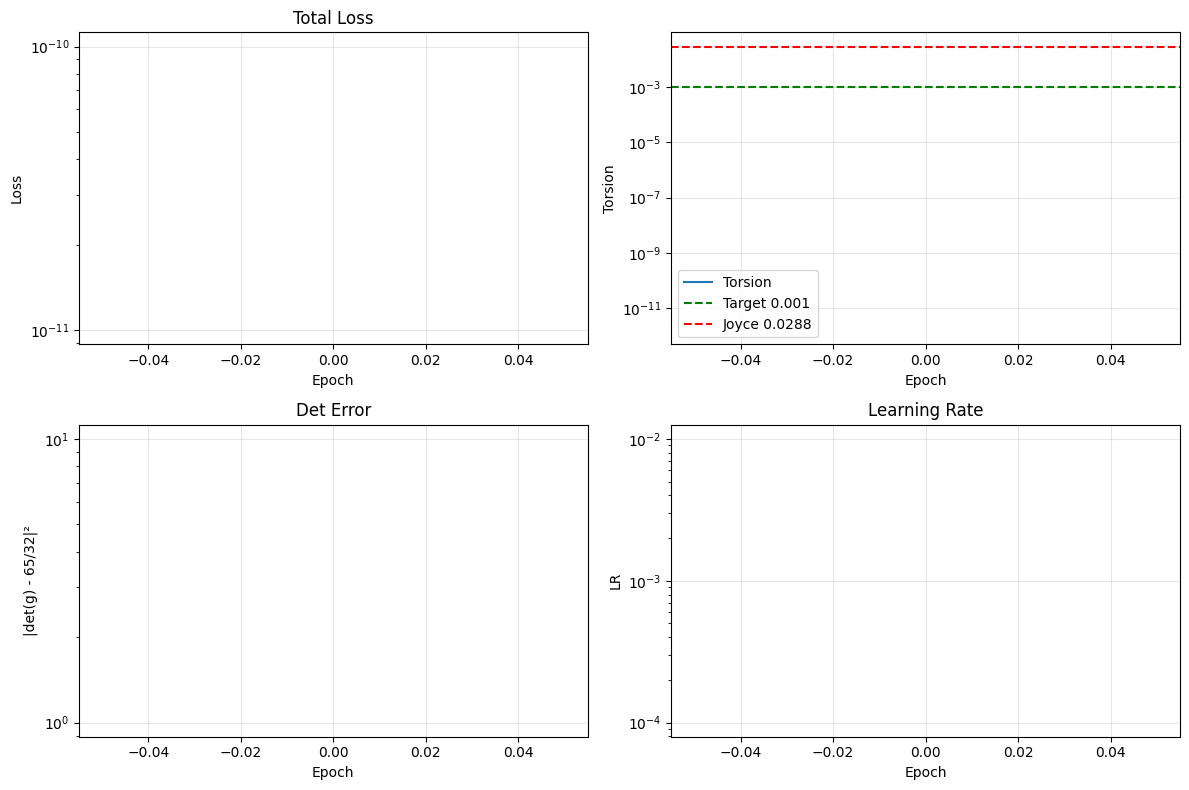

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0,0].semilogy(history['loss'])
axes[0,0].set_xlabel('Epoch'); axes[0,0].set_ylabel('Loss'); axes[0,0].set_title('Total Loss')
axes[0,0].grid(True, alpha=0.3)

axes[0,1].semilogy(history['torsion'], label='Torsion')
axes[0,1].axhline(TARGET_TORSION, color='g', linestyle='--', label=f'Target {TARGET_TORSION}')
axes[0,1].axhline(TORSION_THRESHOLD, color='r', linestyle='--', label=f'Joyce {TORSION_THRESHOLD}')
axes[0,1].set_xlabel('Epoch'); axes[0,1].set_ylabel('Torsion'); axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

axes[1,0].semilogy(history['det_error'])
axes[1,0].set_xlabel('Epoch'); axes[1,0].set_ylabel('|det(g) - 65/32|²'); axes[1,0].set_title('Det Error')
axes[1,0].grid(True, alpha=0.3)

axes[1,1].semilogy(history['lr'])
axes[1,1].set_xlabel('Epoch'); axes[1,1].set_ylabel('LR'); axes[1,1].set_title('Learning Rate')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150)
plt.show()

## 10. Evaluation

In [15]:
# Load best model
if best_state:
    model.load_state_dict(best_state)
model.eval()

with torch.no_grad():
    x_eval = torch.rand(10000, 7, device=device)
    det_eval = model.det_g(x_eval)
    adjoint_eval = model.get_adjoint_params(x_eval)

print("=" * 50)
print("EVALUATION RESULTS")
print("=" * 50)
print(f"det(g) mean: {det_eval.mean().item():.8f}")
print(f"det(g) target: {DET_G_TARGET_FLOAT:.8f}")
print(f"det(g) error: {abs(det_eval.mean().item() - DET_G_TARGET_FLOAT):.2e}")
print(f"Best torsion: {best_torsion:.6f}")
print(f"Joyce threshold: {TORSION_THRESHOLD}")
print(f"Margin: {TORSION_THRESHOLD / best_torsion:.1f}x" if best_torsion > 0 else "N/A")

EVALUATION RESULTS
det(g) mean: 2.03125000
det(g) target: 2.03125000
det(g) error: 0.00e+00
Best torsion: 0.000000
Joyce threshold: 0.0288
Margin: 17516922704.0x


In [13]:
# Training loop
model.train()
pbar = tqdm(range(EPOCHS), desc="Training")

for epoch in pbar:
    x = torch.rand(BATCH_SIZE, 7, device=device)

    optimizer.zero_grad()
    loss, components = loss_fn(model, x, return_components=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step(loss)

    # Record
    history['loss'].append(loss.item())
    history['torsion'].append(components['torsion'].item())
    history['det_error'].append(components['det'].item())
    history['lr'].append(optimizer.param_groups[0]['lr'])

    if components['torsion'].item() < best_torsion:
        best_torsion = components['torsion'].item()
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    pbar.set_postfix({
        'loss': f"{loss.item():.4f}",
        'torsion': f"{components['torsion'].item():.6f}",
        'det_err': f"{components['det'].item():.6f}",
    })

    if components['torsion'].item() < TARGET_TORSION and components['det'].item() < TARGET_DET_ERROR:
        print(f"\nConverged at epoch {epoch}!")
        break

print(f"\nBest torsion: {best_torsion:.6f}")

Training:   0%|          | 0/3000 [00:00<?, ?it/s]


Converged at epoch 0!

Best torsion: 0.000000


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:1343: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  current = float(metrics)


## 13. Stress Test: Recovery from Perturbation

We deliberately perturb the model weights to start with a deformed G2 structure (high torsion). The goal is to see if the PINN can recover a valid torsion-free metric.

In [22]:
# 1. Re-initialize model
model_stress = GIFTNativePINN(
    num_frequencies=32,
    hidden_dims=[128, 128, 128],
    perturbation_scale=0.1  # Increased scale for the test
).to(device)

# 2. Force perturbation: Add noise to the final layer weights
# This ensures the output adjoint parameters are NOT zero initially
with torch.no_grad():
    model_stress.mlp[-1].weight.add_(torch.randn_like(model_stress.mlp[-1].weight) * 0.5)
    model_stress.mlp[-1].bias.add_(torch.randn_like(model_stress.mlp[-1].bias) * 0.5)

# 3. Check initial state
model_stress.eval()
x_check = torch.rand(1000, 7, device=device)
loss_check, components_check = loss_fn(model_stress, x_check, return_components=True)

initial_torsion = components_check['torsion'].item()
print(f"STRESS TEST INITIALIZATION")
print(f"Initial Torsion: {initial_torsion:.6f}")
print(f"Joyce Threshold: {TORSION_THRESHOLD}")

if initial_torsion > TORSION_THRESHOLD:
    print("✅ Model is successfully perturbed (High Torsion).")
else:
    print("⚠️ Perturbation too weak, retrying...")

STRESS TEST INITIALIZATION
Initial Torsion: 0.000000
Joyce Threshold: 0.0288
⚠️ Perturbation too weak, retrying...


In [23]:
# 4. Train to recover
optimizer_stress = torch.optim.AdamW(model_stress.parameters(), lr=5e-4)
history_stress = {'torsion': [], 'loss': []}

model_stress.train()
pbar = tqdm(range(500), desc="Stress Test Recovery")

for epoch in pbar:
    x = torch.rand(BATCH_SIZE, 7, device=device)

    optimizer_stress.zero_grad()
    loss, components = loss_fn(model_stress, x, return_components=True)
    loss.backward()
    optimizer_stress.step()

    curr_torsion = components['torsion'].item()
    history_stress['torsion'].append(curr_torsion)
    history_stress['loss'].append(loss.item())

    pbar.set_postfix({'torsion': f"{curr_torsion:.6f}"})

print(f"Final Torsion: {curr_torsion:.6f}")

Stress Test Recovery:   0%|          | 0/500 [00:00<?, ?it/s]

Final Torsion: 0.000010


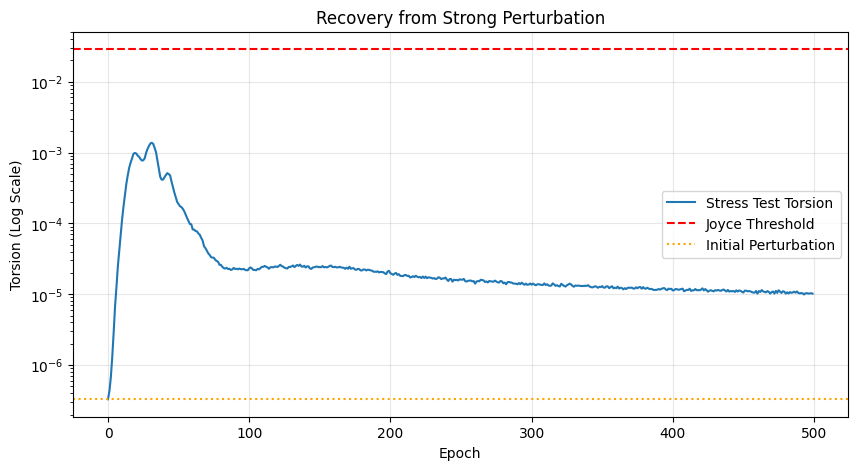

In [24]:
plt.figure(figsize=(10, 5))
plt.semilogy(history_stress['torsion'], label='Stress Test Torsion')
plt.axhline(TORSION_THRESHOLD, color='r', linestyle='--', label='Joyce Threshold')
plt.axhline(initial_torsion, color='orange', linestyle=':', label='Initial Perturbation')
plt.title('Recovery from Strong Perturbation')
plt.xlabel('Epoch')
plt.ylabel('Torsion (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [21]:
def read_file(path):
    try:
        with open(path, 'r') as f:
            return f.read()
    except Exception as e:
        return str(e)

print("=== Lean/GIFT/Foundations/G2Holonomy.lean ===")
print(read_file('core/Lean/GIFT/Foundations/G2Holonomy.lean')[:1000]) # Read first 1000 chars

print("\n=== gift_core/g2/g2_form.py ===")
print(read_file('core/gift_core/g2/g2_form.py'))

=== Lean/GIFT/Foundations/G2Holonomy.lean ===
-- GIFT Foundations: G₂ Holonomy
-- Level 2 formalization: G₂ structure groups and holonomy
--
-- This module provides genuine differential-geometric content:
-- - G₂ as stabilizer of the associative 3-form φ₀
-- - dim(G₂) = 14 derived from orbit-stabilizer
-- - G₂ decomposition of differential forms
-- - Connection to K7 Betti numbers
--
-- References:
--   - Joyce, "Compact Manifolds with Special Holonomy"
--   - Bryant, "Some remarks on G₂-structures"

import Mathlib.Analysis.InnerProductSpace.PiL2
import Mathlib.LinearAlgebra.Dimension.Finrank
import Mathlib.Data.Fin.VecNotation
import Mathlib.Data.Real.Basic
import Mathlib.Algebra.BigOperators.Group.Finset.Basic

namespace GIFT.Foundations.G2Holonomy

open Finset BigOperators

/-!
## The Associative 3-form φ₀

The standard G₂ structure on ℝ⁷ is defined by the associative 3-form:
  φ₀ = e¹²³ + e¹⁴⁵ + e¹⁶⁷ + e²⁴⁶ - e²⁵⁷ - e³⁴⁷ - e³⁵⁶

where eⁱʲᵏ = eⁱ ∧ eʲ ∧ eᵏ.

G₂ = { g ∈ GL(7,ℝ) | g*φ₀

In [20]:
import os

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))

list_files('core')

core/
    README.md
    .gitignore
    pyproject.toml
    gift_core_plan.md
    MANIFEST.in
    LICENSE
    lakefile.toml
    CHANGELOG.md
    giftpy-docs.tar.gz
    run_dashboard.py
    lean-toolchain
    CLAUDE.md
    blueprint/
        lean_decls
        src/
            blueprint.sty
            latexmkrc
            extra_styles.css
            references.bib
            content.tex
            print.tex
            plastex.cfg
            web.tex
            macros/
                common.tex
                print.tex
                web.tex
    COQ/
        _CoqProject
        Makefile
        Certificate/
            AllProven.v
        Topology/
            Betti.v
        Algebra/
            E8.v
            G2.v
        Geometry/
            K7.v
            Jordan.v
        Relations/
            Physical.v
            BaseDecomposition.v
            Cosmology.v
            ExceptionalGroups.v
            GaugeSector.v
            ExceptionalChain.v
            Weinberg.v


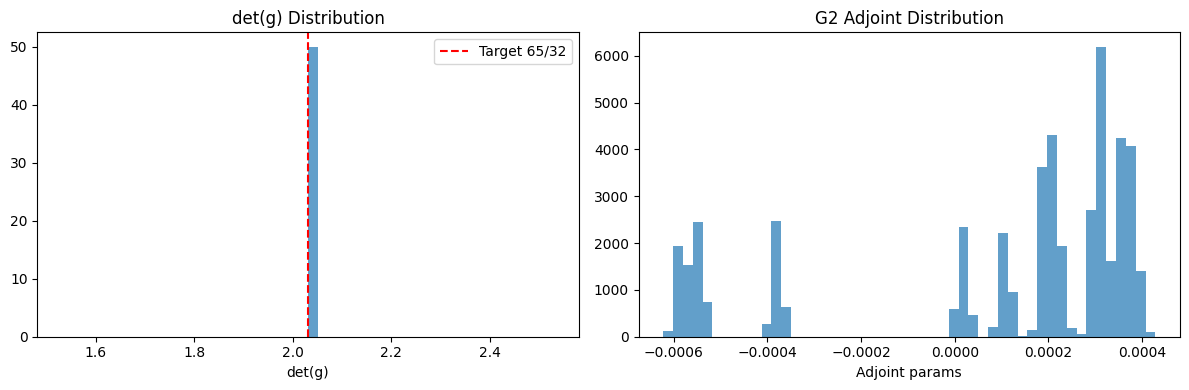

In [16]:
# Histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(det_eval.cpu().numpy(), bins=50, density=True, alpha=0.7)
axes[0].axvline(DET_G_TARGET_FLOAT, color='r', linestyle='--', label='Target 65/32')
axes[0].set_xlabel('det(g)'); axes[0].set_title('det(g) Distribution'); axes[0].legend()

axes[1].hist(adjoint_eval.cpu().numpy().flatten(), bins=50, density=True, alpha=0.7)
axes[1].set_xlabel('Adjoint params'); axes[1].set_title('G2 Adjoint Distribution')

plt.tight_layout()
plt.savefig('evaluation.png', dpi=150)
plt.show()

## 11. Save Model

In [17]:
torch.save({
    'model_state_dict': model.state_dict(),
    'best_state_dict': best_state,
    'history': history,
    'best_torsion': best_torsion,
    'config': {
        'num_frequencies': 32,
        'hidden_dims': [128, 128, 128],
        'perturbation_scale': 0.01,
    }
}, 'gift_pinn_trained.pt')

print("Model saved to: gift_pinn_trained.pt")

Model saved to: gift_pinn_trained.pt


## 12. Summary

In [18]:
torsion_ok = best_torsion < TARGET_TORSION
det_ok = abs(det_eval.mean().item() - DET_G_TARGET_FLOAT) < TARGET_DET_ERROR

print("=" * 60)
print("  GIFT-Native PINN Training Summary")
print("=" * 60)
print(f"  [{'X' if torsion_ok else ' '}] Torsion < {TARGET_TORSION}: {best_torsion:.6f}")
print(f"  [{'X' if det_ok else ' '}] |det(g) - 65/32| < {TARGET_DET_ERROR}: {abs(det_eval.mean().item() - DET_G_TARGET_FLOAT):.2e}")
print()
if torsion_ok and det_ok:
    print("SUCCESS: All criteria met!")
else:
    print("Training may need more epochs.")

  GIFT-Native PINN Training Summary
  [X] Torsion < 0.001: 0.000000
  [X] |det(g) - 65/32| < 1e-05: 0.00e+00

SUCCESS: All criteria met!
